In [1]:
import os
import re

import fasttext
from iso639 import languages
import gensim
from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import altair as alt

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN,KMeans

In [2]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

## Loading csvs and model

In [3]:
mod = KeyedVectors.load("word2vecmodels/docs_grams_final.model")

In [4]:
df = pd.DataFrame(mod.index_to_key, columns=["d2vtag"])

In [5]:
plotdir = "plots/"

We reduce the dimensionality of the doc2vec representation with TSNE

In [6]:
xy_tsne = TSNE(n_components=2,n_jobs=-1,random_state=42).fit_transform(mod.vectors)

In [7]:
df[["TSNE_x", "TSNE_y"]] = xy_tsne

In [8]:
clustering = DBSCAN(eps=3, min_samples=2,n_jobs=-1).fit(mod.vectors)
df["db_lab"] = clustering.labels_

In [9]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(mod.vectors)
df["k_lab"] = kmeans.labels_

In [10]:
dataset = pd.read_csv("songlyrics/songs_with_filenames_and_feats_6.csv", delimiter=";")
dataset = dataset[dataset['filename'].notna()]

We add the new data to the other features

In [11]:
joined = dataset.set_index('filename').join(df.set_index('d2vtag')).reset_index()

In [12]:
joined.head()

index                      id  \
0            # fuori c'è il sole_Lorenzo Fragola.txt  2lCT4RVgR0bIYR0JW7Mcqx   
1                        #Beautiful_Mariah Carey.txt  1ahAuX3F6tDdNRfMdiLsv6   
2  #FREETRAFFIK (feat. Traffik & Oni One)_Dark Po...  62CXPxRcQcVLzBnRLqumVg   
3                       #SELFIE_The Chainsmokers.txt  1HOlb9rdNOmy9b1Fakicjo   
4                           #thatPOWER_will.i.am.txt  01TuObJVd7owWchVRuQbQw   

     tag_fimi publisher album_release_date album_type  \
0  sony music       sme         2015-03-31      album   
1         uni       NaN         2014-05-27      album   
2      virgin       uni         2020-09-04      album   
3    republic       uni         2014-01-01     single   
4         uni       NaN         2013-01-01      album   

                                song_name                album_id  \
0                     # fuori c'è il sole  0jDgMZrhUnBCPTH0W9sxRD   
1                              #Beautiful  6hGRm1piHNE0Xp7I5Guesy   
2  #FREETRAFFIK (feat. Traffik & Oni One)  7508al6lFNaTBwdKsKwOR4   
3                                 #SELFIE  3OeA4rJ9XJNAygyNyTc2sI   
4                              #thatPOWER  0VWYRbEcvJcPrqMGJirO6q   

                              artists_names  \
0                       ['Lorenzo Fragola']   
1                ['Mariah Carey', 'Miguel']   
2  ['Dark Polo Gang', 'Traffik', 'Oni One']   
3                      ['The Chainsmokers']   
4            ['will.i.am', 'Justin Bieber']   

                                          artists_id  ... instrumentalness  \
0                         ['0tTS475qIqv3KXYZMXjsYy']  ...         0.000000   
1  ['4iHNK0tOyZPYnBU7nGAgpQ', '360IAlyVv4PCEVjgyM...  ...         0.000000   
2  ['4CuMwzDzEdlUJMEna38VQ0', '5JVKdHw7BhuMqSSBVx...  ...         0.000000   
3                         ['69GGBxA162lTqCwzJG5jLp']  ...         0.000008   
4  ['085pc2PYOi8bGKj0PNjekA', '1uNFoZAHBGtllmzznp...  ...         0.000077   

   liveness  valence    tempo            type  duration_ms     TSNE_x  \
0    0.4380    0.612   91.011  audio_features          4.0 -24.439049   
1    0.2980    0.425  107.030  audio_features     199947.0  28.872093   
2    0.1030    0.529  125.856  audio_features     164864.0 -41.902637   
3    0.0770    0.658  127.956  audio_features          4.0  27.178978   
4    0.0748    0.402  127.999  audio_features     279507.0  47.694077   

      TSNE_y  db_lab  k_lab  
0  17.561127       0      1  
1  15.085300      -1      0  
2 -24.340891      -1      5  
3  -8.421482      -1      0  
4 -10.524613      -1      9  

[5 rows x 30 columns]

## Features engineering

Adding the name of the first song of each artist as a feature

In [14]:
def unpack_artist_list(str_repr):
    output = []
    try:
        output.extend(eval(str_repr))
    except:
        output.append(str_repr)
    finally:
        return output

In [15]:
firstart = []
for artist in joined["artists_names"]:
    firstart.append(unpack_artist_list(artist)[0])
joined["firstart"] = firstart

Adding the year of publication of each song

In [16]:
joined['year'] = pd.DatetimeIndex(joined['album_release_date']).year

Using fasttext pretrained model for detecting a given song's language

In [17]:
PRETRAINED_MODEL_PATH = 'fastext_models/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [18]:
DATA = "songlyrics/lyrics"

In [19]:
langs= list()
intros = list()
for song in joined["index"]:
    with open(os.path.join(DATA,song),"r",encoding='utf-8') as file:
        lyrics = file.read()
        lyrics = re.sub("\n"," ",lyrics)
        intros.append(lyrics[:400])
        fasttex_pred = model.predict(lyrics)[0][0][9:]
        try:
            code = languages.get(alpha2=fasttex_pred).name
        except:
            code = languages.get(part3=fasttex_pred).name
        finally:
            langs.append(code)

Adding the song language and a snipped of its lyrics to the dataset

In [20]:
joined["lang"] = langs
joined["intros"] = intros

In [21]:
joined.loc[joined["db_lab"] == 5,"lang"] = "Neapolitan"
joined.loc[joined["db_lab"] == 7,"lang"] = "Neapolitan"

In [22]:
langdict = joined[["id","lang"]].set_index("id").to_dict()["lang"]

In [23]:
full_df = pd.read_csv("../../data/combined_df_final_nospace.csv", delimiter=";", parse_dates=True, infer_datetime_format=True)

In [24]:
full_df["lang"] = full_df["id"].map(langdict)

Full charts datasets with langs information

In [25]:
full_df.to_csv("cleaned_df_v6_with_langs.csv",sep=";",index=False)

Distinct Songs with lang information

In [26]:
joined.to_csv("songs_with_filenames_and_feats_and_lang_6.csv", sep=";", index=False)

## Timeseries of languages

We group by date and we calculate the percentage of each lanuage in a said week

In [27]:
lang_counts = full_df.groupby(["date_chart","lang"]).size().unstack(fill_value=0)
lang_counts = lang_counts.div(lang_counts.sum(axis=1), axis=0).reset_index()

In [28]:
lang_counts['date_chart'] = pd.to_datetime(lang_counts['date_chart'], format= '%d.%m.%Y')

In [29]:
lang_counts = lang_counts.set_index("date_chart")

We isolate English, Italian , Spanish and Neapolitn, we resample by month and we decompose each time series, keeping only the trend

In [30]:
langs = [lang_counts['English'], lang_counts['Italian'], lang_counts['Spanish'], lang_counts['Neapolitan']]
langs = list(map(lambda x : (x.name, x.resample("M").mean()),langs))
trens = list(map(lambda x : (x[1].name, seasonal_decompose(x[1]).trend),langs))

We plot using plt

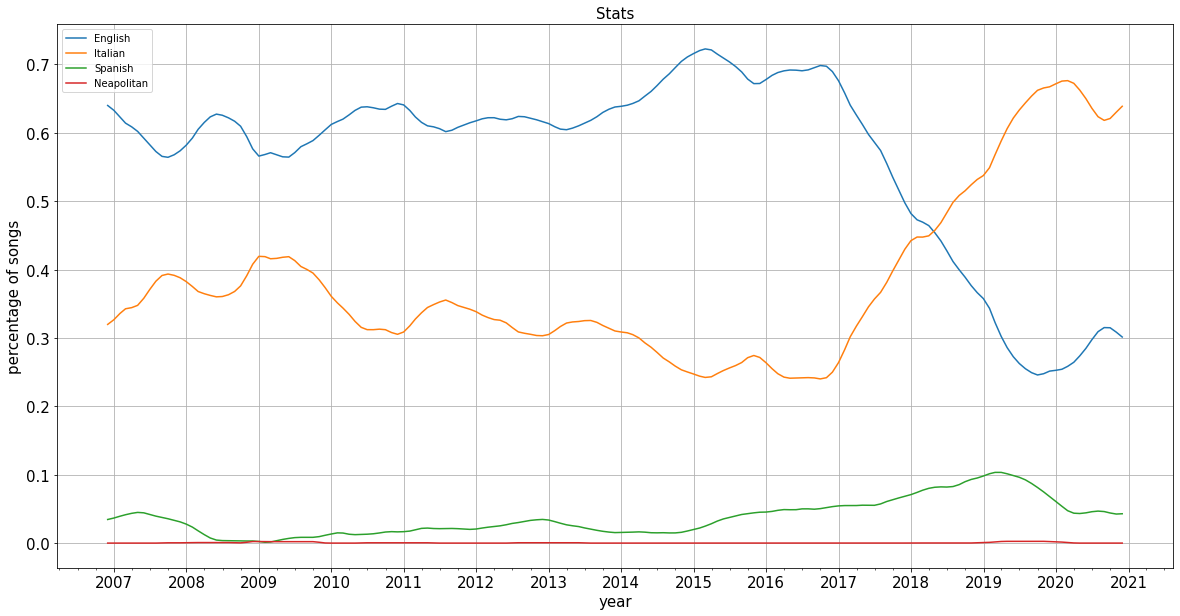

In [32]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

for lan in trens: 
    plt.plot(lan[1], label=lan[0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("percentage of songs", fontsize=15)

plt.savefig(plotdir + "langs_time.png", dpi=300)

plt.show()

Count of songs per language

In [ ]:
points = alt.Chart(pd.DataFrame(joined.lang.value_counts().iloc[:4],columns=["lang"]).reset_index()).mark_bar(
    opacity=0.8
).encode(
    y = alt.Y('index', sort="-x", title="language"),
    x = alt.X('lang',title="count of songs"),
    color = "index"
    )
al = points
al.properties(
    width=800,
    height=500
)

In [33]:
al.save(plotdir + 'counts.html')

## Plotting the doc2vec representation with Altair

In [38]:
lang_filter = {
"Italian":"Italian",                  
"English":"English",                  
"Spanish":"Spanish",                   
"Neapolitan":"Neapolitan",                
"French":"French",                  
"Portuguese":"Portuguese",  
"Turkish": "Other",                   
"Korean": "Other",                      
"Modern Greek (1453-)": "Other",        
"German": "Other",                     
"Romanian": "Other",                    
"Lithuanian": "Other",                 
"Latin": "Other",                       
"Finnish": "Other",                     
"Esperanto": "Other",                  
"Arabic": "Other",                      
"Malay (macrolanguage)": "Other",     
"Japanese": "Other",                    
"Polish": "Other",                     
"Icelandic": "Other",                   
"Russian" : "Other",                    
"Serbian" : "Other",                   
"Tagalog" : "Other",                    
"Albanian": "Other"            
}

In [39]:
joined["lang_vis"] = joined["lang"].map(lang_filter)

In [46]:
points = alt.Chart(joined).mark_circle(
    opacity=0.5,
    size=50
).encode(
    x='TSNE_x',
    y='TSNE_y',
    tooltip=["song_name", "artists_names", "album_release_date", "tag_fimi","publisher","album_release_date", "lang", "intros", 'explicit'],
    color=alt.Color('lang_vis:N')
)
al = points.interactive().properties(
    width=1280,
    height=720)
al

alt.Chart(...)

In [47]:
al.save(plotdir + 'doc2vec.html')

## Debugging

Debuggining code used to detect "problematic" clusters (e.g. songs with lyrics which are not "proper" lyrics/garbage data)
We use DBSCAN to isolate those cluster and fix the text files manually

In [58]:
defective = pd.concat([joined[joined["db_lab"] == 2], joined[joined["db_lab"] == 6]])

In [60]:
defective = defective[["id", "song_name", "artists_names"]]
defective["song_name_less"] = defective["song_name"].str.replace(r"(-.+|\(.+\))", "")

<ipython-input-60-e4dbe52a73d0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  defective["song_name_less"] = defective["song_name"].str.replace(r"(-.+|\(.+\))", "")


In [61]:
defective.to_csv("defective_cluster.csv", index=False, sep=";")